In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform, AbsTransform

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

from hbmep_paper.utils import simulate
from hbmep_paper.utils.constants import HBM

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/experiments.toml")

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/effect-size/"


2023-08-10 14:37:15,493 - hbmep.config - INFO - Verifying configuration ...
2023-08-10 14:37:15,493 - hbmep.config - INFO - Success!


In [3]:
from hbmep_paper.model import Simulator


simulator = Simulator(config=config)

simulation_params = {
    "n_subject": 3,
    "n_feature0": 10,
    "n_repeats": 10,
    "downsample_rate": 1
}
df, posterior_samples_true = simulate(model=simulator, **simulation_params)

# ind = (df.participant == 3) & (df.compound_position == 0)
# df = df[ind].reset_index(drop=True).copy()

2023-08-10 14:37:23,017 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-10 14:37:23,018 - hbmep_paper.utils.utils - INFO - Simulating data ...


2023-08-10 14:37:28,581 - hbmep.utils.utils - INFO - func:predict took: 5.56 sec
2023-08-10 14:37:28,583 - hbmep.utils.utils - INFO - func:simulate took: 5.57 sec


In [4]:
model = Baseline(config=config)
df, encoder_dict = model.load(df=df)

obs = np.array(posterior_samples_true[site.obs])
df[model.response] = obs[0, ...]

2023-08-10 14:37:33,551 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-08-10 14:37:33,552 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/effect-size/
2023-08-10 14:37:33,552 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/effect-size/
2023-08-10 14:37:33,553 - hbmep.dataset.core - INFO - Processing data ...
2023-08-10 14:37:33,555 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
model.plot(df=df, encoder_dict=encoder_dict)


2023-08-10 14:37:40,180 - hbmep.dataset.core - INFO - Plotting dataset ...
2023-08-10 14:37:53,064 - hbmep.dataset.core - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/effect-size/dataset.pdf
2023-08-10 14:37:53,065 - hbmep.utils.utils - INFO - func:plot took: 12.89 sec


In [117]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns


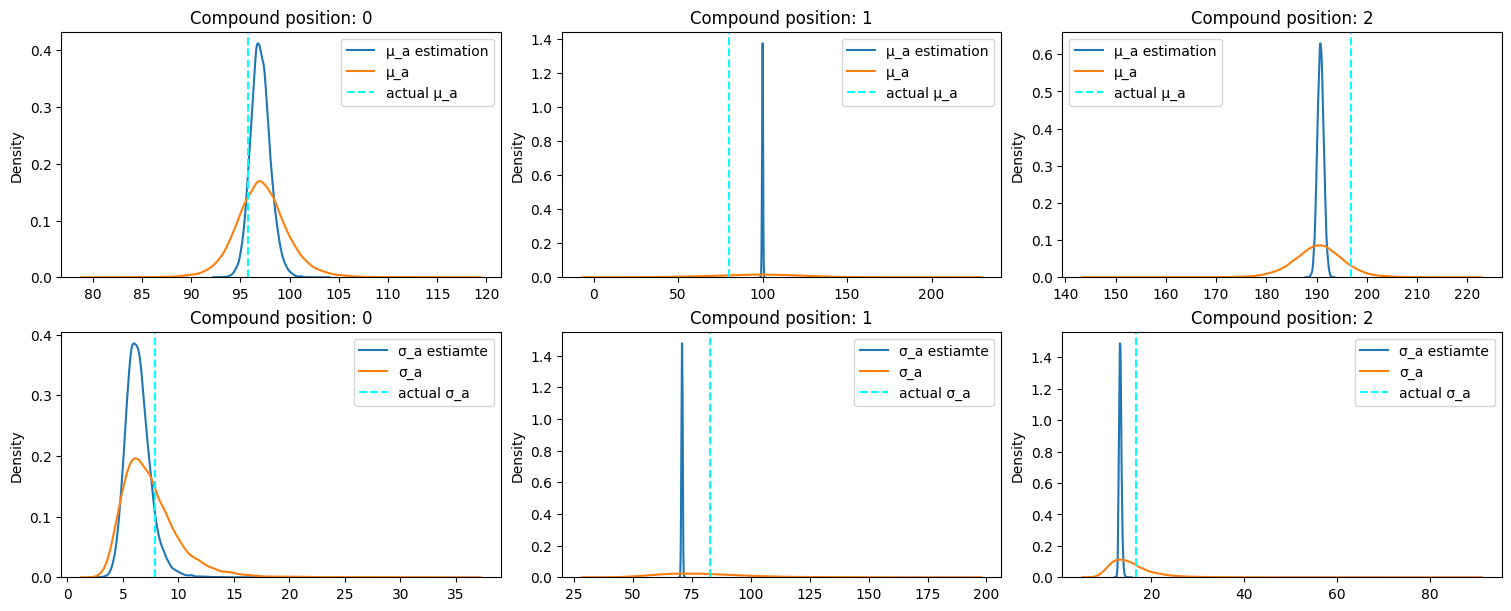

In [134]:
run_id = 9

src = f"/home/vishu/repos/hbmep-paper/reports/down-sampled/1/hb/run{run_id}/hierarchical_bayesian/mcmc.nc"
mcmc = az.from_netcdf(src)["posterior"]

a = mcmc[site.a].to_numpy().reshape(-1, 10, 3, 1)
a = a[..., 0]

mu_a = mcmc[site.mu_a].to_numpy().reshape(-1, 3, 1)
mu_a = mu_a[..., 0]

sigma_a = mcmc[site.sigma_a].to_numpy().reshape(-1, 3, 1)
sigma_a = sigma_a[..., 0]

mu_a_estimate = a.mean(axis=1)
sigma_a_estimate = np.power(np.power(a - a.mean(axis=1)[:, None, :], 2).sum(axis=1) / 9, 0.5)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(3 * 5, 3 * 2), constrained_layout=True)

for i in range(3):
    ax = axes[0, i]
    sns.kdeplot(mu_a_estimate[:, i], label=f"{site.mu_a} estimation", ax=ax)
    sns.kdeplot(mu_a[:, i], label=f"{site.mu_a}", ax=ax)
    ax.axvline(posterior_samples_true[site.mu_a][run_id - 1, i, 0], label=f"actual {site.mu_a}", color="cyan", linestyle="dashed")
    ax.set_title(f"Compound position: {i}")
    ax.legend()

for i in range(3):
    ax = axes[1, i]
    sns.kdeplot(sigma_a_estimate[:, i], label=f"{site.sigma_a} estiamte", ax=ax)
    sns.kdeplot(sigma_a[:, i], label=f"{site.sigma_a}", ax=ax)
    ax.axvline(posterior_samples_true[site.sigma_a][run_id - 1, i, 0], label=f"actual {site.sigma_a}", color="cyan", linestyle="dashed")
    ax.set_title(f"Compound position: {i}")
    ax.legend()

In [96]:
posterior_samples_true.keys()

dict_keys(['H', 'L', 'a', 'b', 'g_1', 'g_2', 'obs', 'v', 'µ', 'µ_a', 'β', 'σ_H', 'σ_L', 'σ_a', 'σ_b', 'σ_v'])

In [52]:
a.shape

(24000, 10, 3)

In [51]:
mu_a.shape

(24000, 3)

In [75]:
a.shape

(24000, 10, 3)

In [93]:
np.power(np.power(a - a.mean(axis=1)[:, None, :], 2).sum(axis=1) / 9, 0.5)

(24000, 3)

In [53]:
a_ = a[:, :, 0]
a_.shape

(24000, 10)

In [57]:
a_.mean(axis=-1).shape

(24000,)

<Axes: ylabel='Density'>

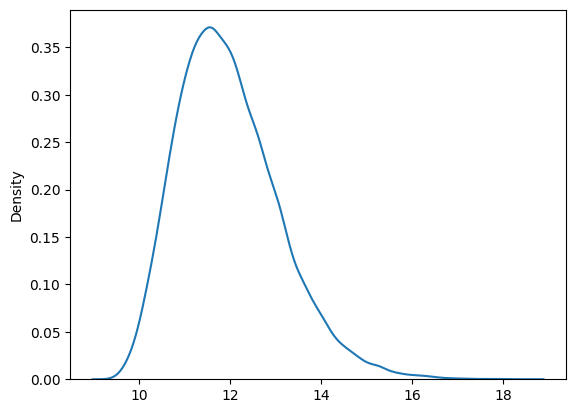

In [81]:
samples = np.power((np.power((a_.T - a_.T.mean(axis=0)).T, 2).sum(axis=1)) / 9, 0.5)

sns.kdeplot(samples)

array([143.00363485, 159.06710875, 128.15466432, ..., 151.47907089,
       141.89391128, 126.32856551])

In [56]:
a_ - a_.mean(axis=-1)

ValueError: operands could not be broadcast together with shapes (24000,10) (24000,) 

In [12]:
mcmc.keys()

KeysView(<xarray.Dataset>
Dimensions:    (chain: 4, draw: 6000, H_dim_0: 10, H_dim_1: 3, H_dim_2: 1,
                L_dim_0: 10, L_dim_1: 3, L_dim_2: 1, a_dim_0: 10, a_dim_1: 3,
                a_dim_2: 1, b_dim_0: 10, b_dim_1: 3, b_dim_2: 1, g_1_dim_0: 10,
                g_1_dim_1: 3, g_1_dim_2: 1, g_2_dim_0: 10, g_2_dim_1: 3,
                g_2_dim_2: 1, v_dim_0: 10, v_dim_1: 3, v_dim_2: 1,
                µ_dim_0: 2700, µ_dim_1: 1, µ_a_dim_0: 3, µ_a_dim_1: 1,
                β_dim_0: 2700, β_dim_1: 1, σ_H_dim_0: 3, σ_H_dim_1: 1,
                σ_L_dim_0: 3, σ_L_dim_1: 1, σ_a_dim_0: 3, σ_a_dim_1: 1,
                σ_b_dim_0: 3, σ_b_dim_1: 1, σ_v_dim_0: 3, σ_v_dim_1: 1)
Coordinates: (12/39)
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 5993 5994 5995 5996 5997 5998 5999
  * H_dim_0    (H_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * H_dim_1    (H_dim_1) int64 0 1 2
  * H_dim_2    (H_dim_2) int64 0
  * L_dim_0    (L_dim_0) int64 0 1 2 3 4 5 6 7 8 9
    

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-08-10 14:32:57,231 - hbmep.model.baseline - INFO - Running inference with REC ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
import arviz as az

numpyro_data = az.from_numpyro(mcmc)

In [14]:
numpyro_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [18]:
mcmc.print_summary(exclude_deterministic=False)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     H[0,0,0]      0.43      0.41      0.39      0.29      0.54   1039.22      1.02
     H[0,1,0]      3.15      0.63      3.00      2.32      4.08    651.16      1.03
     H[0,2,0]      5.43      4.11      4.08      1.51     10.58   1224.23      1.01
     H[1,0,0]      0.31      0.01      0.31      0.30      0.32  15979.20      1.00
     H[1,1,0]      4.56      0.02      4.56      4.53      4.59  59747.28      1.00
     H[1,2,0]      5.34      4.33      4.00      0.83     10.92    754.88      1.02
H_base[0,0,0]      0.06      0.82      0.17     -1.26      1.39     14.19      1.93
H_base[0,1,0]      0.24      0.77      0.52     -1.02      1.27     11.75      2.74
H_base[0,2,0]      0.32      1.15      0.57     -1.60      2.07     13.45      2.12
H_base[1,0,0]     -0.19      0.60     -0.27     -1.13      0.88     14.65      1.84
H_base[1,1,0]     -0.30      1.14     -0.74     -1.71      1.61     11.52  

In [11]:
az.summary(numpyro_data, var_names=[site.a, site.b, site.L, site.H, site.v])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0, 0]",128.718,1.813,125.309,131.895,0.018,0.013,10711.0,14505.0,1.00
"a[0, 1, 0]",218.203,0.703,216.880,219.469,0.010,0.007,4617.0,21486.0,1.01
"a[0, 2, 0]",264.656,0.309,264.062,265.193,0.002,0.001,22189.0,44993.0,1.00
"a[1, 0, 0]",136.545,0.734,135.261,137.952,0.008,0.006,7859.0,22961.0,1.00
"a[1, 1, 0]",187.668,0.062,187.553,187.782,0.000,0.000,38571.0,60223.0,1.00
"a[1, 2, 0]",247.241,0.104,247.046,247.431,0.000,0.000,71795.0,71961.0,1.00
"b[0, 0, 0]",0.018,0.012,0.004,0.040,0.000,0.000,1070.0,1472.0,1.02
"b[0, 1, 0]",0.024,0.010,0.009,0.042,0.000,0.000,439.0,2149.0,1.04
"b[0, 2, 0]",0.075,0.056,0.007,0.174,0.002,0.001,945.0,1254.0,1.02
"b[1, 0, 0]",0.086,0.031,0.047,0.141,0.001,0.001,1436.0,4478.0,1.02


In [19]:
p = mcmc.get_samples(group_by_chain=True)

In [20]:
a = np.array(p[site.a])
b = np.array(p[site.b])
g_1 = np.array(p[site.g_1])
g_2 = np.array(p[site.g_2])

In [ ]:
q = mcmc.get_samples(group_by_chain=True)
a_ = np.array(q["a"])
g_1_ = np.array(q[site.g_1])
g_2_ = np.array(q[site.g_2])

In [ ]:
potential = mcmc.get_extra_fields(group_by_chain=True)["potential_energy"]

In [ ]:
import seaborn as sns

y0, y1, y2 = 0, 0, 0
x = np.linspace(0, 1, 4000)
var = a

for i in range(20):
    sns.lineplot(x=x, y=var[i, :, y0, y1, y2], label=f"{i}")

ValueError: All arrays must be of the same length

<Axes: ylabel='Density'>

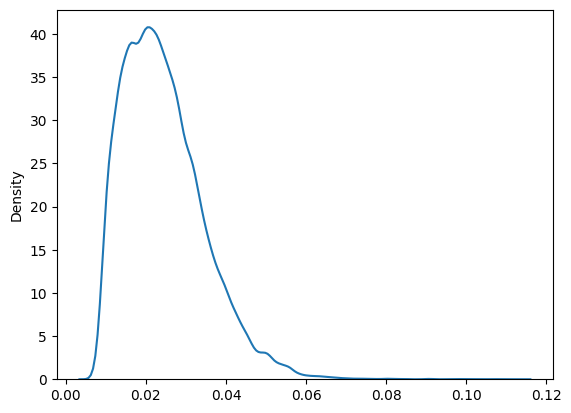

In [25]:
sns.kdeplot(posterior_samples["b"][:, 0, 1, 0])

In [23]:
posterior_samples["b"].shape

(120000, 2, 3, 1)

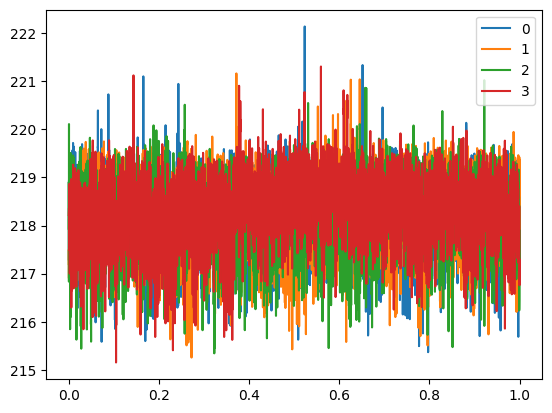

In [21]:
import seaborn as sns

y0, y1, y2 = 0, 1, 0
x = np.linspace(0, 1, 6000)
var = a

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, y0, y1, y2], label=f"{i}")

In [ ]:
posterior_samples["a"].shape

(120000, 2, 3, 1)

In [ ]:
t.participant += 1

In [ ]:
t.compound_position += 1

In [ ]:
t = df.copy()

In [10]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-07 12:26:24,911 - hbmep.model.baseline - INFO - Generating predictions ...


2023-08-07 12:26:49,147 - hbmep.utils.utils - INFO - func:predict took: 24.23 sec
2023-08-07 12:26:49,248 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-08-07 12:26:52,935 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/2/recruitment_curves.pdf
2023-08-07 12:26:52,936 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 28.03 sec


In [11]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-07 12:26:52,983 - hbmep.model.baseline - INFO - Generating predictions ...


2023-08-07 12:27:17,076 - hbmep.utils.utils - INFO - func:predict took: 24.09 sec
2023-08-07 12:27:17,253 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-08-07 12:27:30,498 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/2/posterior_predictive_check.pdf
2023-08-07 12:27:30,500 - hbmep.utils.utils - INFO - func:render_predictive_check took: 37.52 sec
